# Mixture Density Network
I learn MDN thanks to this post from @hardmaru
Source: http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/

I took his code and adapted it so it can generate an output that contains multiples dimentions

## Init environement and setup some helpers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [2]:
def tf_assert_shape(tensor, requested_shape):
  shape = tensor.get_shape().as_list()
  error_msg = 'Tensor {} has shape {} while shape {} was requested'.format(tensor.name, shape, requested_shape)
  assert shape == requested_shape, error_msg

## Generate some data

### Data dimentions

In [3]:
BATCH_SIZE = 2500
NSAMPLE = BATCH_SIZE
DIM = 3  # number of dimentions

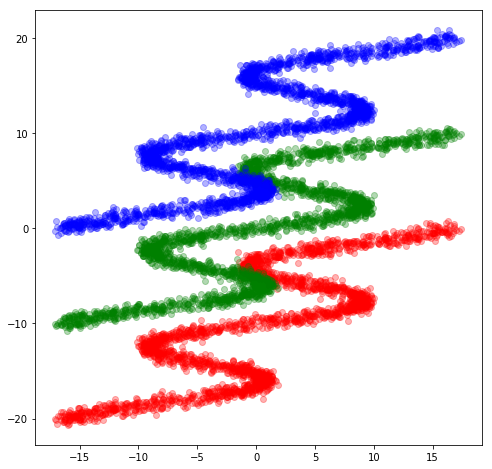

In [4]:
offset_data = np.float32(np.linspace(-10, 10, num=DIM))
y_data_one = np.float32(np.random.uniform(-10, 10, (NSAMPLE, 1)))
y_data = np.float32(np.random.uniform(-10, 10, (NSAMPLE, DIM)))
r_x = np.float32(np.random.normal(size=(NSAMPLE, 1)))
r_y = np.float32(np.random.normal(size=(NSAMPLE, 3)))
x_data= np.float32(np.sin(0.75*y_data_one)*7.0+y_data_one*1+r_x*0.4)

y_data[:,0] = y_data_one[:,0]
y_data[:,1] = y_data_one[:,0] 
y_data[:,2] = y_data_one[:,0] 
y_data = y_data + offset_data + r_y*0.4

plt.figure(figsize=(8, 8))
plt.plot(x_data , y_data[:,0],'ro', alpha=0.3)
plt.plot(x_data , y_data[:,1],'go', alpha=0.3)
plt.plot(x_data , y_data[:,2],'bo', alpha=0.3)
plt.show()

## Model

The model is a simple multilayer perceptrons with one hidden layer.

But instead of outputing one value for every output dimention, the neural network estimate the distribution of the output using a mixture au gaussian.

So the number of output neurons needed for one value is KMIX * 3, where KMIX is the number of guaussian needed to model the distribution and 3 because each gaussian is defined by 3 values: pi, mu and sigma.

The model is defined in two part.
* the multilayer perception
* the mixture density model


In [5]:
NHIDDEN = 24
STDEV = 0.5

KMIX = 10  # number of mixtures
NOUT = KMIX * DIM * 3  # pi, mu, sigma

FLOAT_TYPE = tf.float64

# Define input (x) and output (y)
# output can be higher dimension than x
x = tf.placeholder(dtype=FLOAT_TYPE, shape=[BATCH_SIZE, 1], name="x")
y = tf.placeholder(dtype=FLOAT_TYPE, shape=[BATCH_SIZE, DIM], name="y")

# Define coeficients
Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=FLOAT_TYPE))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=FLOAT_TYPE))
Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=FLOAT_TYPE))
bo = tf.Variable(tf.random_normal([1, NOUT], stddev=STDEV, dtype=FLOAT_TYPE))

# connect layers
hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

In [6]:
# get_mixture_coef take the output of a model and convert it to a mixture model
def get_mixture_coef(output, batch_size, data_size, mixture_size):
  tf_assert_shape(output, [batch_size, data_size * mixture_size * 3])  # 3 stand for pi, mu, stdev
  
  # split the output
  out_pi, out_sigma, out_mu = tf.split(output, 3, axis=1)
  tf_assert_shape(out_pi, [batch_size, data_size * mixture_size])
  tf_assert_shape(out_sigma, [batch_size, data_size * mixture_size])
  tf_assert_shape(out_mu, [batch_size, data_size * mixture_size])

  # reshape pi, sigma and mu
  new_shape = [batch_size, data_size, mixture_size]
  out_pi = tf.reshape(out_pi, new_shape)
  out_sigma = tf.reshape(out_sigma, new_shape)
  out_mu = tf.reshape(out_mu, new_shape)
  tf_assert_shape(out_pi, new_shape)
  tf_assert_shape(out_sigma, new_shape)
  tf_assert_shape(out_mu, new_shape)

  # pi is a distribution
  out_pi = tf.nn.softmax(out_pi, axis=2)
  # sigma value are on an exponetial scale
  out_sigma = tf.exp(out_sigma)

  return out_pi, out_sigma, out_mu

In [7]:
# Add the mixture model to the tf graph
out_pi, out_sigma, out_mu = get_mixture_coef(output, NSAMPLE, DIM, KMIX)

## Add the loss

In [8]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.
def tf_normal(y, mu, sigma, batch_size, data_size):
  # check args
  tf_assert_shape(y, [batch_size, data_size])
  tf_assert_shape(mu, [batch_size, data_size, KMIX])
  tf_assert_shape(sigma, [batch_size, data_size, KMIX])
  
  y = tf.reshape(y, (batch_size, data_size, 1))  # add one dim to ease broadcast
  tf_assert_shape(y, [batch_size, data_size, 1])
  result = tf.subtract(y, mu)  # Broadcast should work now
  tf_assert_shape(result, [batch_size, data_size, KMIX])
  result = tf.multiply(result, tf.reciprocal(sigma))  # element wise
  result = -tf.square(result)/2  # element wise
  tf_assert_shape(result, [batch_size, data_size, KMIX])
  return tf.multiply(tf.exp(result), tf.reciprocal(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y, batch_size, data_size):
  # check args
  tf_assert_shape(y, [batch_size, data_size])
  tf_assert_shape(out_pi, [batch_size, data_size, KMIX])
  tf_assert_shape(out_sigma, [batch_size, data_size, KMIX])
  tf_assert_shape(out_mu, [batch_size, data_size, KMIX])
  
  normal = tf_normal(y, out_mu, out_sigma, batch_size, data_size)
  tf_assert_shape(normal, [batch_size, data_size, KMIX])
  result = tf.multiply(normal, out_pi)  # element wise
  tf_assert_shape(result, [batch_size, data_size, KMIX])
  result = tf.reduce_sum(result, axis=2)
  tf_assert_shape(result, [batch_size, data_size])
  result = -tf.log(result)
  tf_assert_shape(result, [batch_size, data_size])
  result = tf.reduce_mean(result)
  tf_assert_shape(result, [])
  return result

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y, NSAMPLE, DIM)
train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(lossfunc)

## Trainning

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

NEPOCH = 15000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
  loss[i], _ = sess.run((lossfunc, train_op), feed_dict={x: x_data, y: y_data})
  if i%500 == 0:
    print ('step:',i,'loss:',loss[i])

Instructions for updating:
Use `tf.global_variables_initializer` instead.
step: 0 loss: 6.78669445407
step: 500 loss: 1.80072491711
step: 1000 loss: 1.66012796212
step: 1500 loss: 1.52525430291
step: 2000 loss: 1.49373983795
step: 2500 loss: 1.48444396182
step: 3000 loss: 1.47971749119
step: 3500 loss: 1.4744639625
step: 4000 loss: 1.46613128166
step: 4500 loss: 1.46173937832
step: 5000 loss: 1.45898437098
step: 5500 loss: 1.45423345118
step: 6000 loss: 1.45152248282
step: 6500 loss: 1.45067715627
step: 7000 loss: 1.44993855016
step: 7500 loss: 1.44726355915
step: 8000 loss: 1.4482080127
step: 8500 loss: 1.44978541643
step: 9000 loss: 1.4450258093
step: 9500 loss: 1.44480141392
step: 10000 loss: 1.45545179456
step: 10500 loss: 1.44559676093
step: 11000 loss: 1.44483720605
step: 11500 loss: 1.44256830521
step: 12000 loss: 1.44243369215
step: 12500 loss: 1.44058743416
step: 13000 loss: 1.44195239298
step: 13500 loss: 1.43948043227
step: 14000 loss: 1.438751231
step: 14500 loss: 1.4395364

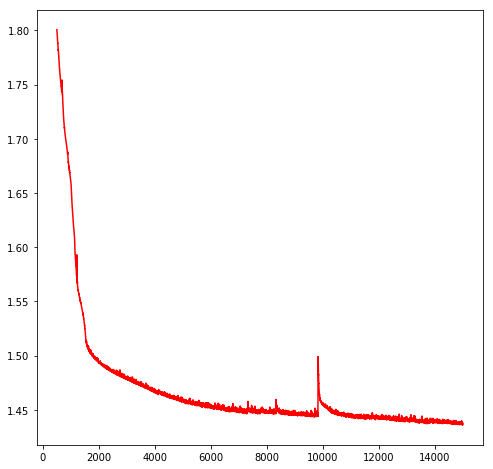

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(500, NEPOCH,1), loss[500:], 'r-')
plt.show()

## Sample the model

In [11]:
# Helper fonction to pick a gaussian according to the distribution
def get_pi_idx(x, pdf):
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  print ('error with sampling ensemble',x, np.sum(pdf))
  return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 1):
  NTEST = x_test.size
  result = np.random.rand(NSAMPLE, M) # initially random [0, 1]
  rn = np.random.randn(NSAMPLE, M) # normal random matrix (0.0, 1.0)
  mu = 0
  std = 0
  idx = 0

  # transforms result into random ensembles
  for j in range(0, M):
    for i in range(0, NSAMPLE):
      # print ("M", j, "sample", i, "sum(pdf=out_pi[i])", sum(out_pi[i]))
      idx = get_pi_idx(result[i, j], out_pi[i])
      mu = out_mu[i, idx]
      std = out_sigma[i, idx]
      result[i, j] = mu + rn[i, j]*std
  return result

In [12]:
# generate a new set of inputs
x_test = np.float32(np.arange(-12.5,12.5,0.01))
x_test = x_test[:NSAMPLE]
x_test = x_test.reshape(NSAMPLE, 1) # needs to be a matrix, not a vector

# ask the model to generate 
out_pi_test, out_sigma_test, out_mu_test = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_test})

# generate the output using the model
y_test = {}
for i in range(DIM):
  print("generate DIM", i)
  y_test[i] = generate_ensemble(out_pi_test[:,i,:], out_mu_test[:,i,:], out_sigma_test[:,i,:], M=1)

generate DIM 0
generate DIM 1
generate DIM 2


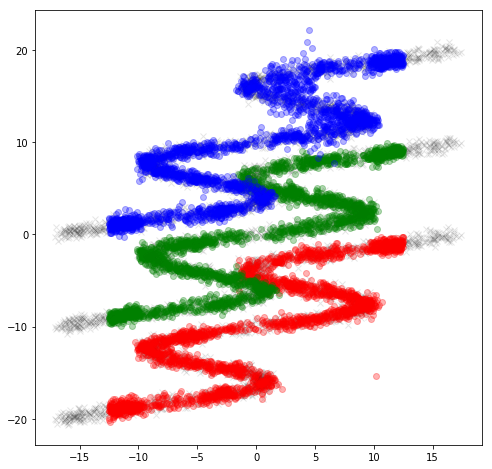

In [13]:
plt.figure(figsize=(8, 8))

plt.plot(x_data , y_data[:,0],'x', alpha=0.1, color='black')
plt.plot(x_data , y_data[:,1],'x', alpha=0.1, color='black')
plt.plot(x_data , y_data[:,2],'x', alpha=0.1, color='black')

plt.plot(x_test, y_test[0],'ro',alpha=0.3)
plt.plot(x_test, y_test[1],'go',alpha=0.3)
plt.plot(x_test, y_test[2],'bo',alpha=0.3)

plt.show()

## inspecting the model

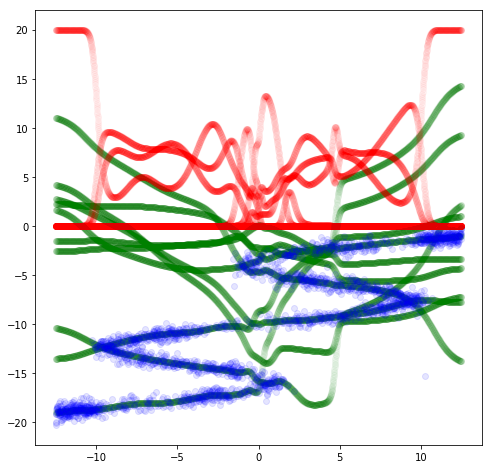

In [14]:
# Inspecting the first dimention mixture model
dim = 0
plt.figure(figsize=(8, 8))
plt.plot(x_test, out_mu_test[:,dim,:],'go', alpha=0.03)
plt.plot(x_test , y_test[dim],'bo',alpha=0.1)
plt.plot(x_test, out_pi_test[:,dim,:]*20,'ro', alpha=0.03)
plt.show()

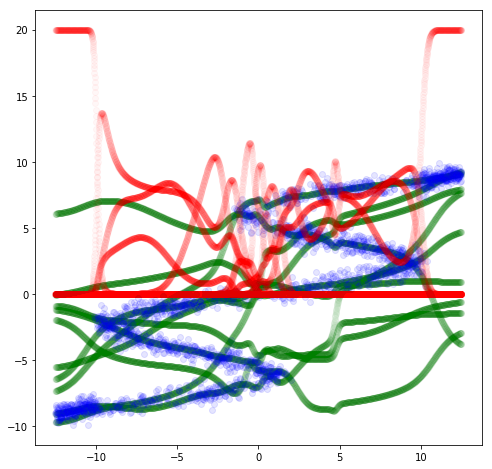

In [15]:
# Inspecting the scond dimention mixture model
dim = 1
plt.figure(figsize=(8, 8))
plt.plot(x_test, out_mu_test[:,dim,:],'go', alpha=0.03)
plt.plot(x_test , y_test[dim],'bo',alpha=0.1)
plt.plot(x_test, out_pi_test[:,dim,:]*20,'ro', alpha=0.03)
plt.show()

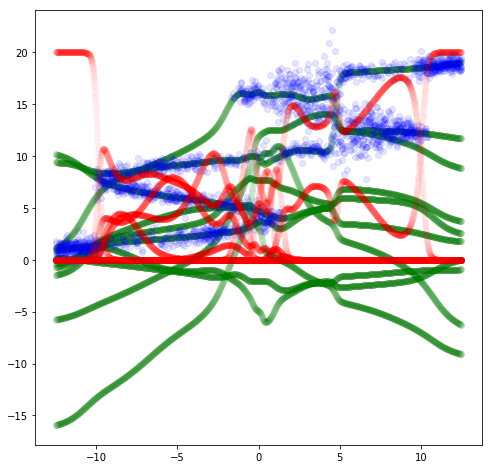

In [16]:
# Inspecting the first dimention mixture model
dim = 2
plt.figure(figsize=(8, 8))
plt.plot(x_test, out_mu_test[:,dim,:],'go', alpha=0.03)
plt.plot(x_test , y_test[dim],'bo',alpha=0.1)
plt.plot(x_test, out_pi_test[:,dim,:]*20,'ro', alpha=0.03)
plt.show()